# Image Deblurring - Luigi Podda

## Introduction
The aim of this project is to build a deep learning model in order to remove gaussian blur and gaussian noise from images.

**Wide Inference Networks (WIN)** are convolutional neural networks, with a wide structure, that in particular are capable of learning pixel-distribution features from noisy data. Moreover, WIN predict reconstructed images from features learned by pixel-distributions. This type of networks work better when the noise is higher, due to the fact that distributions are more similar under higher degree of noise.

In this analysis we compare three different architectures that have a very similar structure: **WIN5, WIN5-R, WIN5-RB**.
* WIN5 is a Wide Inference Network with 5 layers;
* WIN5-R is a Wide Inference Network with 5 layers that deploys a skip connection (i.e. it uses Residual Learning);
* WIN5-RB is almost equivalent with respect to WIN5-R, adding a Batch Normalization layer for each of the previous layers;

![](https://www.researchgate.net/profile/Peng-Liu-68/publication/318528076/figure/fig2/AS:527642848120832@1502811266274/Architectures-a-WIN5-b-WIN5-R-c-WIN5-RB.png)

The main reference for this project is available at the following link:
https://arxiv.org/pdf/1707.09135.pdf

To replicate all the experiments done, the three models' weights (in hdf5 format) are available at the following link:
https://drive.google.com/drive/folders/1lk1GScDehsZAs0c1vcTbwRPhH1qQT0TV?usp=sharing



Importing the necessary libraries

In [ ]:
import tensorflow as tf
import random
from cv2 import GaussianBlur, imread, calcHist
import numpy as np
import random
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Conv2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import layers
import matplotlib.pyplot as plt

## Dataset
`getDataset()` is a function that loads the CIFAR-10 dataset, which is already splitted in training set and testing set. Then data are normalized moving them in the range [0,1]. After that, it has been applied: gaussian blur with a $5\times 5$ kernel and gaussian noise in the entire surface of each image.

Finally, two datasets already split are returned:
* The modified training set
* The original training set
* The modified testing set
* The original testing set

In [ ]:
def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

Let's now load the two datasets already  divided into training and testing sets.

In [ ]:
((blurred_x_train, x_train), (blurred_x_test, x_test)) = getDataset()

# WIN5
The structure of this convolutional neural network is composed by 5 convolutional layers with 64 filters of size $7\times7$ for each layer. In all the three models that we analyze, the first 4 layers have a ReLU activation function, only the last layer does not have an activation function. This means that we are not introducing any non-linear transformation in the last layer of our network.

The size of the kernel in all convlutions is $7\times7$. Its dimension is a trade off between accuracy and efficiency, indeed a larger filter could denoise better the image, however the entire computation becomes more expensive and we are more prone to overfitting.

In this model there are two different types of layers:
* CONV + ReLU
* CONV

In the network the first 4 layers are of the first kind, while the last one is of the second kind. There is another difference between these types of layers, indeed in CONV + ReLU layers the output dimension is 64 (i.e. the number of output filters in the convolution is 64), while in the CONV layer is 3 (the three color channels of the image).

In [ ]:
def win5_model(input_shape, kernel_size):
  input = Input(shape=input_shape)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(input)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(x)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(x)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(x)
  output = Conv2D(3, kernel_size = kernel_size, padding='same')(x)

  model = Model(input, output)
  model.summary()
  return model


Let's now compile the network passing to the `model.compile()` method two mandatory arguments:

* **optimizer**
* **loss function**

As optimizer we chose **Adam**, which implements adaptive learning rate with momentum.

While as loss we use **mean square error** (mse).

In [ ]:
d1 = 32 # input images' width
d2 = 32 # input images' height
kernel_size = 7

In [ ]:
win5 = win5_model((d1, d2, 3), kernel_size)
win5.compile(optimizer='adam', loss='mse')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        9472      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        200768    
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        200768    
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        200768    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 3)         9411      
                                                                 
Total params: 621,187
Trainable params: 621,187
Non-trainable

We fit the model with  the method `model.fit()`, specifing:
* **Training data** composed by blurred images
* **Ground truth** composed by original images
* **Validation data** composed by the test sets of original and blurred images
* The number of **epochs**
* The **batch size** is the default one of 32 samples

When we fit a CNN we are optimizing, accordingly with the specified loss function, the parameters of the network with respect to the training set. The parameters in a fully convolutional neural network are those weights that compose the kernels of the convolutions.

Using as validation data the test set, at the end of each epoch we are computing the loss function (MSE) on the test set, this is done to check the downward trend of the chosen metric and to be sure that the model is not either overfitting or underfitting.
Using validation data, at the end of each epoch the fit function will compute the metrics on the validation set.

In [ ]:
history_win5 = win5.fit(blurred_x_train,
                          x_train,
                          validation_data=(blurred_x_test, x_test),
                          epochs=15)

Epoch 1/15
1563/1563 [==============================] - 41s 24ms/step - loss: 0.0139 - val_loss: 0.0043
Epoch 2/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 3/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 4/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 5/15
1563/1563 [==============================] - 38s 25ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 6/15
1563/1563 [==============================] - 38s 25ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/15
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 8/15
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 9/15
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/15
1563/1563 [==============================] - 39s 25m

Saving the weights

In [ ]:
win5.save_weights('win5_weights', save_format='h5')

`display_history()` is a function that takes as input the history of the training. It is a temporal sequence of the loss and validation loss redurned by `model.fit`. After that the function plots in logarithmic scale the loss' values as well as the validation loss' values.

In [ ]:
def display_history(history):
    mse_training = history.history['loss']
    mse_val = history.history['val_loss']
    # Visualize the behavior of the loss
    plt.yscale('log')
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

Plotting the results obtained after fitting the model we can see how the loss is decreasing; this means that the network is learning the parameters to minimize the mean square error.

The same downward trend can be observed for the validation loss; this is a good sign of how the model is not overfitting.

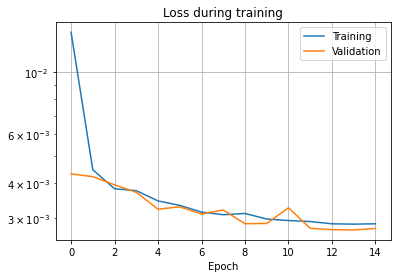

In [ ]:
display_history(history_win5)

We predict the final output using the `model.predict()` method. It receives as input the testing set of blurred images and it returns a dataset containing the reconstructed images.

In [ ]:
predict_win5 = win5.predict(blurred_x_test)

Once that the final dataset has been computed we compare it with the ground truth (i.e. the testing set without any blur and noise).

For the comparison we use the mean square error in order to have a correspondent metric for the training and testing sets.

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
mse_win5 = mse(x_test, predict_win5).numpy()
mse_win5

0.0027538533

Let's now have a visual output of the results obtained with the first model of this comparison: **WIN5**.

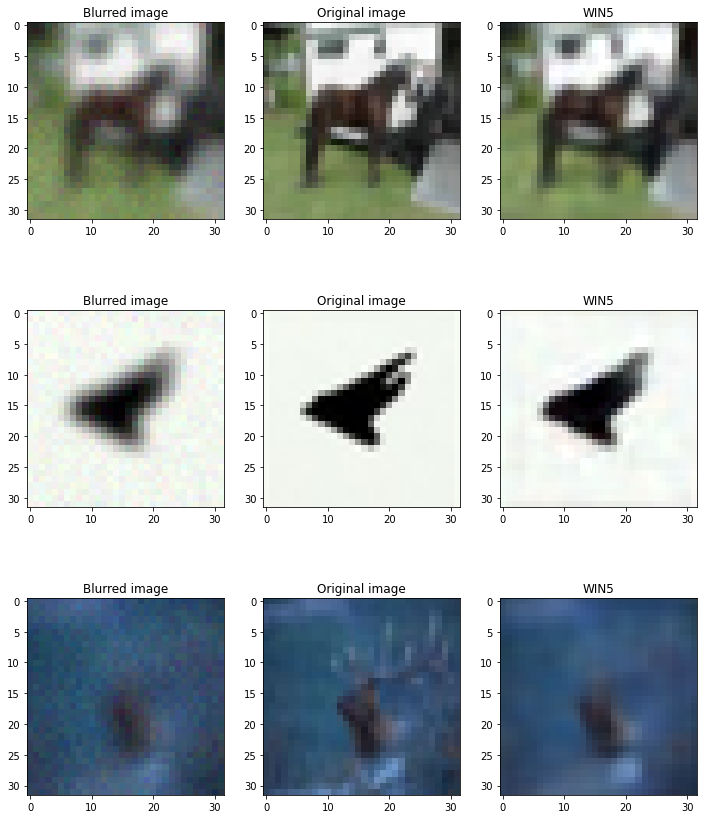

In [ ]:
image = 20

f, axarr = plt.subplots(nrows=3,ncols=3)
f.set_figheight(15)
f.set_figwidth(12)

for i in range(0,3):
  plt.sca(axarr[i][0]);
  plt.imshow(np.clip(blurred_x_test[image+i], 0, 1)); plt.title('Blurred image')
  plt.sca(axarr[i][1]);
  plt.imshow(np.clip(x_test[image+i], 0, 1)); plt.title('Original image')
  plt.sca(axarr[i][2]);
  plt.imshow(np.clip(predict_win5[image+i], 0, 1)); plt.title('WIN5')

plt.show()

# Win5-R
The structure of this model is extremely similar with respect to that one of WIN5, indeed it has two different types of layers:
* CONV + ReLU
* CONV

As before the first 4 layers are of the first kind, while the last one is of the second kind. Also, in CONV + ReLU layers the output dimension is 64 (i.e. the number of output filters in the convolution is 64), while in CONV is 3 (the three color channels of the image).

The only difference with respect to WIN5 is that, in WIN5-R we add a skip connection that connects the input layer with the output layer. This type of connections helps the neural network's optimization; indeed rather than learning the function $F(x)$ the network learns the function $F(x) + x$ and subtracting $x$ it can compute $F(x)$ which can be considered as the inverse of the union of blur and noise.

The implemented skip connection concatenates the input with the output; this allows the network to consider other information during learning without growing the number of parameters.


In [ ]:
def win5_R_model(input_shape, kernel_size):
  input = Input(shape=input_shape)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(input)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(x)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(x)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(x)
  x = Conv2D(3, kernel_size = kernel_size, padding='same')(x)
  output = layers.add([x, input])

  model = Model(input, output)
  model.summary()
  return model

Creating the WIN5-R model and looking at the summary we can see how  the number of parameters is the same as the previous model.

Moreover, we compile the model using **Adam** as optimizer and the **mean square error** as loss function.

In [ ]:
win5_R = win5_R_model((d1, d2, 3), kernel_size)
win5_R.compile(optimizer='adam', loss='mse')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 64)   200768      ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 64)   200768      ['conv2d_6[0][0]']               
                                                                                            

Let's fit the model using `model.fit()` with the same arguments as before.




In [ ]:
history_win5_R = win5_R.fit(blurred_x_train,
                          x_train,
                          validation_data=(blurred_x_test, x_test),
                          epochs=15)

Epoch 1/15
1563/1563 [==============================] - 40s 25ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 2/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 3/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 4/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 5/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/15
1563/1563 [==============================] - 38s 25ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 8/15
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/15
1563/1563 [==============================] - 39s 25ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/15
1563/1563 [==============================] - 38s 24m

Saving the weights

In [ ]:
win5_R.save_weights('win5_R_weights', save_format='h5')

We plot the results obtained after fitting WIN5-R seeing how the loss is decreasing. Also the validation loss is decrasing, this is a clear sign that the model is not overfitting. It is possible to see how the loss function's value is smaller with respect to that one computed with WIN5 as model.

We can see how WIN5-R shows better results than WIN5 for the current task, accordingly with the chosen metric.

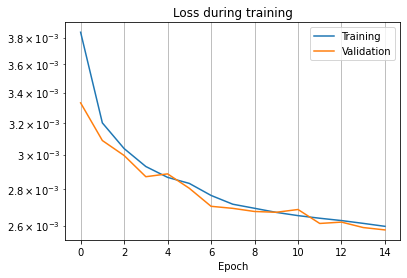

In [ ]:
display_history(history_win5_R)


We build the reconstructed images predicting them from the blurred testing set.

In [ ]:
predict_win5_R = win5_R.predict(blurred_x_test)

We compute the **MSE** for the testing set.

In [ ]:
mse_win5_R = mse(x_test, predict_win5_R).numpy()
mse_win5_R

0.0025772392

Let's now have a visual output of the results obtained with the second model of this comparison: **WIN5-R**.

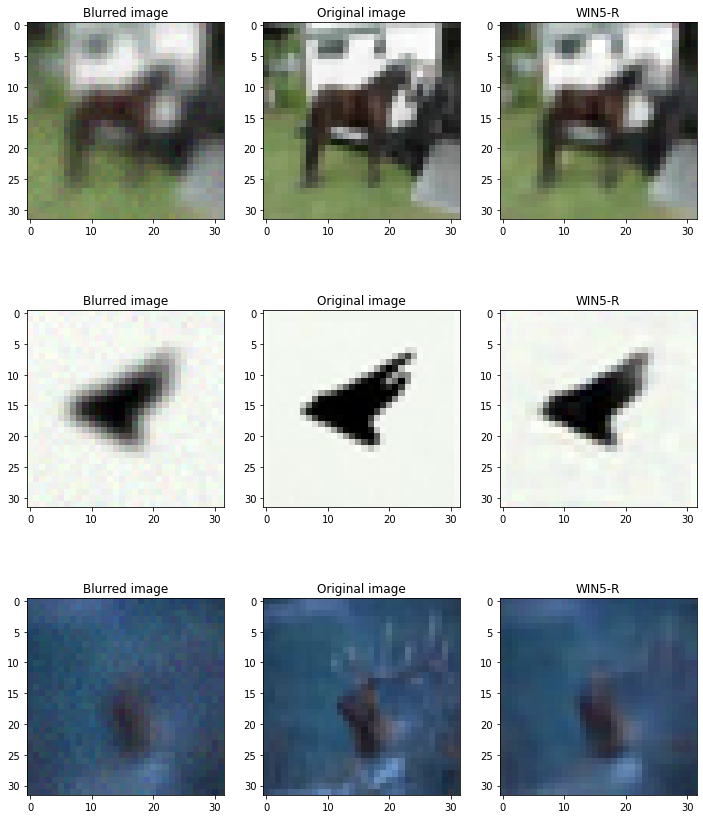

In [ ]:
f, axarr = plt.subplots(nrows=3,ncols=3)
f.set_figheight(15)
f.set_figwidth(12)

for i in range(0,3):
  plt.sca(axarr[i][0]);
  plt.imshow(np.clip(blurred_x_test[image+i], 0, 1)); plt.title('Blurred image')
  plt.sca(axarr[i][1]);
  plt.imshow(np.clip(x_test[image+i], 0, 1)); plt.title('Original image')
  plt.sca(axarr[i][2]);
  plt.imshow(np.clip(predict_win5_R[image+i], 0, 1)); plt.title('WIN5-R')

plt.show()


# WIN5-RB
**(This is the model that has been chosen for the exam. It is the only one that has to be considered for the comparative evaluation of the results)**


Also in this case the structure of the model is almost equivalent with respect to that one of WIN5-R. The only difference is the addition of one Batch Normalization layer for each of the previous layers. This is done to maintain the initial information given by the training set and to preserve the output distribution in order to keep it as similar as possible to the one given as input.

Thanks to this distribution equivalence, the features that are learned from the pixel-distribution are more accurate.

In WIN5-RB the key factor is the combination of the skip connection with Batch normalization layers. Indeed, the absence of the residual learning connection can severely influence the pixel-distribution features due to the missed comparison between input and output distribution.



In [ ]:
def win5_RB_model(input_shape, kernel_size):
  input = Input(shape=input_shape)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(input)
  x = BatchNormalization()(x)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, kernel_size = kernel_size, padding='same', activation="relu")(x)
  x = BatchNormalization()(x)
  x = Conv2D(3, kernel_size = kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  output = layers.add([x, input])

  model = Model(input, output)
  model.summary()
  return model

We create the WIN5-RB model and looking at the summary we can see how  the number of parameters is slightly increased by the addition of BN layers, without having an explosion of them.

We compile the model using **Adam** as optimizer and the **mean square error** as loss function.

In [ ]:
win5_RB = win5_RB_model((d1, d2, 3), kernel_size)
win5_RB.compile(optimizer='adam', loss='mse')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d_10[0][0]']              
 alization)                                                                                       
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 64)   200768      ['batch_normalization[0][0]

Let's fit the model using `model.fit()` with the same arguments used for WIN5.

In [ ]:
history_win5_RB = win5_RB.fit(blurred_x_train,
                          x_train,
                          validation_data=(blurred_x_test, x_test),
                          epochs=15)

Epoch 1/15
1563/1563 [==============================] - 43s 27ms/step - loss: 0.2200 - val_loss: 0.0057
Epoch 2/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 3/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 4/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 5/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 6/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 8/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/15
1563/1563 [==============================] - 42s 27m

Saving the weights

In [ ]:
win5_RB.save_weights('win5_RB_weights', save_format='h5')

Plotting the results obtained fitting WIN5-RB we see how the MSE as well as the validation loss are decreasing, meaning that the model is not overfitting. In addition the loss function's value is smaller with respect to the values computed for both WIN5 and WIN5-R.

It is possible to affirm that we have an improvement in the WIN5-RB results with respect to that ones obtained using the two previous models in executing this task, accordingly with the chosen metric.

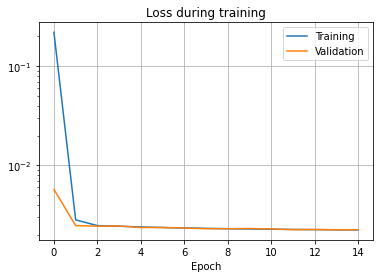

In [ ]:
display_history(history_win5_RB)

To have a more precise representation of the previous plot we focus on the last 14 epochs. From them, it is possible to better capture the downward trend that the loss as well as the validation loss are carrying out. This validation loss' behavior is an explicit signal of good fitting.

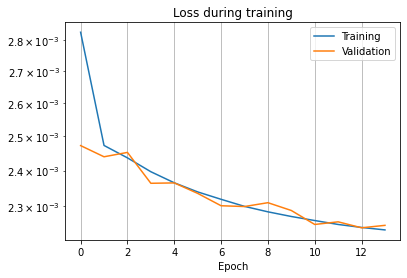

In [ ]:
history_win5_RB_copy = history_win5_RB
history_win5_RB_copy.history['loss'] = history_win5_RB.history['loss'][1:]
history_win5_RB_copy.history['val_loss'] = history_win5_RB.history['val_loss'][1:]
display_history(history_win5_RB_copy)

We build the reconstructed images predicting them from the blurred test set.

In [ ]:
predict_win5_RB = win5_RB.predict(blurred_x_test)

We compute the MSE for the testing set. This is the final value of the validation loss function previously computed.

In [ ]:
mse_win5_RB = mse(x_test, predict_win5_RB).numpy()
mse_win5_RB

0.00224914

Let's now have a visual output of the results obtained with the third model of this comparison: **WIN5-RB**.

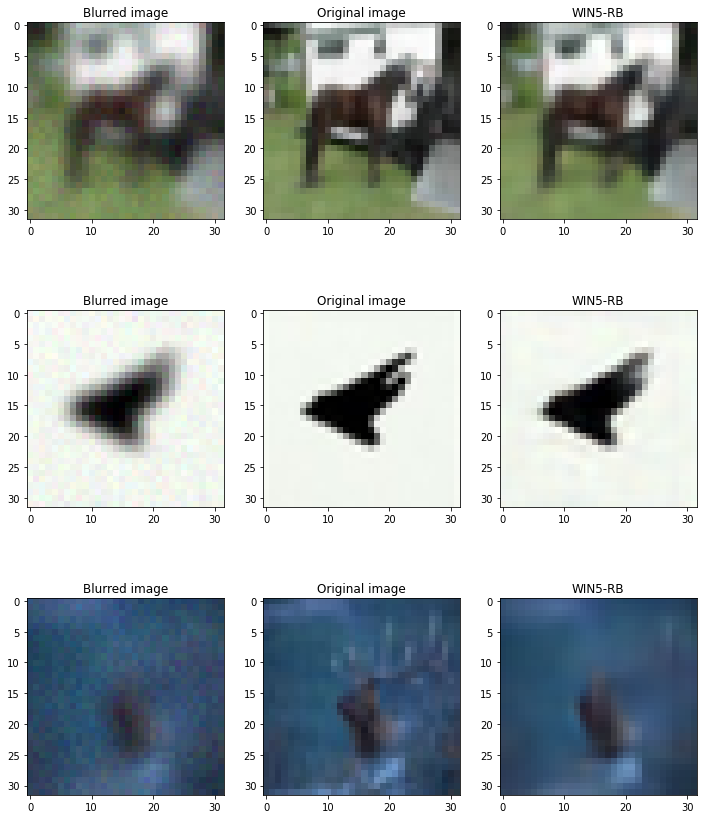

In [ ]:
f, axarr = plt.subplots(nrows=3,ncols=3)
f.set_figheight(15)
f.set_figwidth(12)

for i in range(0,3):
  plt.sca(axarr[i][0]);
  plt.imshow(np.clip(blurred_x_test[image+i], 0, 1)); plt.title('Blurred image')
  plt.sca(axarr[i][1]);
  plt.imshow(np.clip(x_test[image+i], 0, 1)); plt.title('Original image')
  plt.sca(axarr[i][2]);
  plt.imshow(np.clip(predict_win5_RB[image+i], 0, 1)); plt.title('WIN5-RB')

plt.show()

# Model comparison
In the table below we summarize the results obtained for the three different models: **WIN5, WIN5-R, WIN5-RB**

We finally deduce that the model that reaches the best MSE in this comparison is **WIN5-R**

In [ ]:
print("\t val_loss")
print("WIN5:    {}".format(mse_win5))
print("WIN5-R:  {}".format(mse_win5_R))
print("WIN5-RB: {}".format(mse_win5_RB))

	 val_loss
WIN5:    0.0027538533322513103
WIN5-R:  0.0025772391818463802
WIN5-RB: 0.0022491400595754385


Furthermore we show a visual comparison of the reconstructed images given by the models. Visualizing a batch of images, we can see how WIN5-RB reaches also better visual results with respect to the other two models, especially in uniform regions.

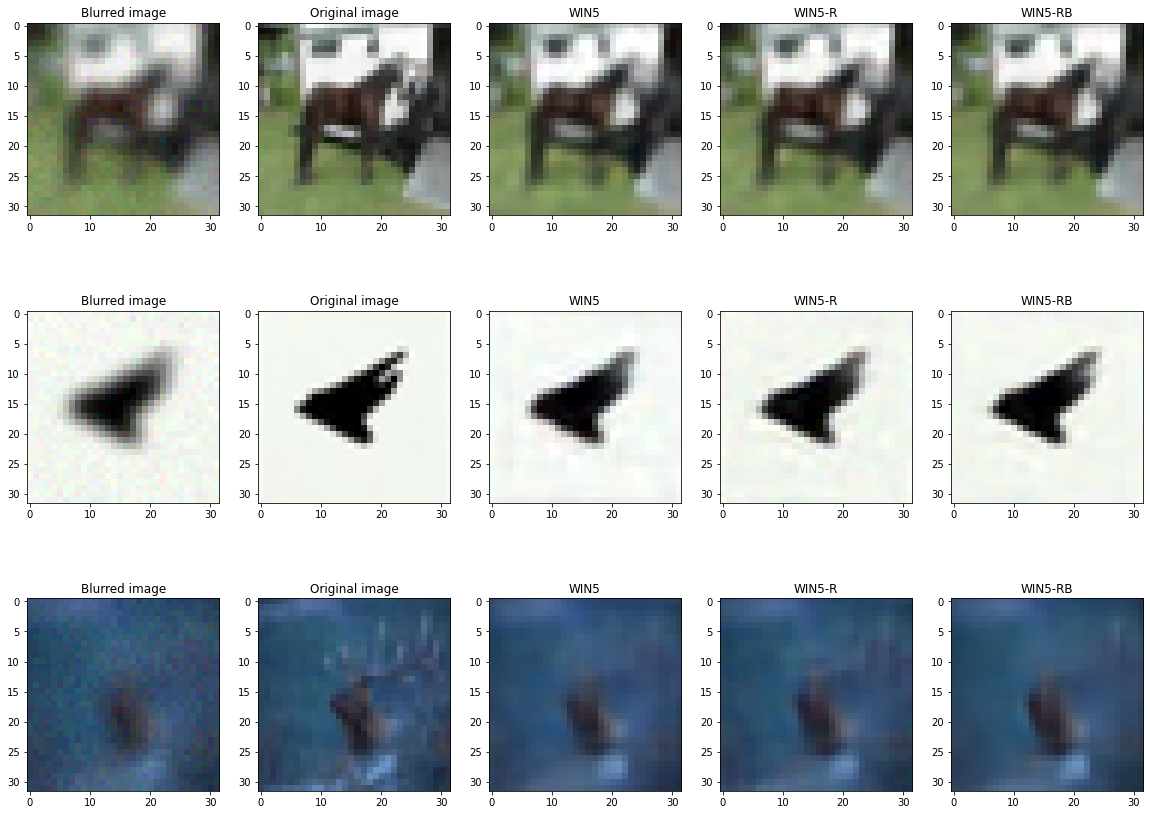

In [ ]:
f, axarr = plt.subplots(nrows=3,ncols=5)
f.set_figheight(15)
f.set_figwidth(20)

for i in range(0,3):
  plt.sca(axarr[i][0]);
  plt.imshow(np.clip(blurred_x_test[image+i], 0, 1)); plt.title('Blurred image')
  plt.sca(axarr[i][1]);
  plt.imshow(np.clip(x_test[image+i], 0, 1)); plt.title('Original image')
  plt.sca(axarr[i][2]);
  plt.imshow(np.clip(predict_win5[image+i], 0, 1)); plt.title('WIN5')
  plt.sca(axarr[i][3]);
  plt.imshow(np.clip(predict_win5_R[image+i], 0, 1)); plt.title('WIN5-R')
  plt.sca(axarr[i][4]);
  plt.imshow(np.clip(predict_win5_RB[image+i], 0, 1)); plt.title('WIN5-RB')

plt.show()